In [18]:
import librosa
import pandas as pd
import numpy as np
import os
import wave
from audio_handler import DemoAudioHandler
import matplotlib.pyplot as plt
%matplotlib inline

# Feature Extracttion

In [3]:
def loadfile(fname):
    with wave.open(fname, 'rb') as wf:
        # print(wf.getnchannels())
        # print(wf.getframerate())
        # print(wf.getparams())
        frames = wf.readframes(wf.getnframes())
        # print(len(frames))
        # print(frames)
        audio_data = frames
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        return audio_array
        
def extract_mfccs(audio_file_path):
    n_mfcc = 10
    audio_array = loadfile(audio_file_path)
    mfccs = librosa.feature.mfcc(y=audio_array.astype('float32'), 
                              sr=8000, n_mfcc=10,dtype=np.float32)
    # y, sr = librosa.load(audio_file_path)
    # mfccs = librosa.feature.mfcc(y=y, sr=8000, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

def extract_mfccs_proper(audio_file_path):
    n_mfcc = 10
    y, sr = librosa.load(audio_file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=8000, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

In [19]:
# too lazy to figure out how to elimininate index without IO
esccsv = "./data/esc_50/meta/esc50.csv" 
escmeta = pd.read_csv(esccsv) 

clean_esc50 = escmeta[escmeta['category'] != "crying_baby"].filter(['filename'],axis=1)
clean_esc50.insert(1,'classification','negative')
clean_esc50.to_csv('intermediate.csv', index=False)
clean_esc50 = pd.read_csv('intermediate.csv')

cry_esc50 = escmeta[escmeta['category'] == "crying_baby"].filter(['filename'],axis=1)
cry_esc50.insert(1,'classification','positive')
cry_esc50.to_csv('intermediate.csv', index=False)
cry_esc50 = pd.read_csv('intermediate.csv')

## Dataframes for pos and negative

In [23]:
cries_list = np.array([[fname,category] for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
cries = pd.DataFrame(cries_list, columns = ['filename', 'classification'])
cries_det = cries.assign(classification='positive')
cries_det.head()

,filename,classification
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,positive
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,positive
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,positive
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,positive
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,positive


In [47]:
neg_set = clean_esc50
pos_set = pd.concat([cry_esc50, cries_det])

In [54]:
# it's quite hacky but will need to have different mfccs for training and for showing
# this is due to how the live data needs to be streamed in int16 even though the training data is stored
# in float32 -> for the live data even though the mfccs are wrong, the outputs are deterministic meaning
# we still have correct classifiction if we load the training data in the same, incorrect, way

# to avoid this would require some deeper debugging and still would not garruentee we can fix it without 
# a higher quality mic or without some sort of preproccessing

#TLDR: bug as a feature
demo_detection_labels = pd.concat([neg_set,pos_set])
live_detection_labels = pd.concat([neg_set,pos_set])

## Extracting MFCCs

In [17]:
audio_files = []
cry_esc50_data_path = "./data/esc_50/audio"
cry_esc50_audio_files = np.array([f"{cry_esc50_data_path}/{fname}" for fname in cry_esc50['filename']])
audio_files.extend(cry_esc50_audio_files)

neg_data_path = "./data/esc_50/audio"
neg_audio_files = np.array([f"{neg_data_path}/{fname}" for fname in clean_esc50['filename']]) 
audio_files.extend(neg_audio_files)

cry_data_path = "./data/donateacry_cleaned"
cry_categories = [cat for cat in os.listdir(cry_data_path) if cat != 'README.md']
cry_audio_files = np.array([f"{cry_data_path}/{category}/{fname}" for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
audio_files.extend(cry_audio_files)

In [34]:
demo_detection_set.head()

,filename,classification
0,1-100032-A-0.wav,negative
1,1-100038-A-14.wav,negative
2,1-100210-A-36.wav,negative
3,1-100210-B-36.wav,negative
4,1-101296-A-19.wav,negative


In [30]:
mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in audio_files:
    mfcc_vector = extract_mfccs_proper(audio_file_path)
    mfcc_vectors.append(mfcc_vector)

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [33]:
n_mfcc = 10
mfcc_df = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])
mfcc_df.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,-283.467499,103.699036,9.822460,32.781723,5.638542,-11.626588,-2.628025,0.126076,-0.993172,-3.018559
1,-248.950760,36.808964,-48.659748,0.121757,5.919672,-1.763860,1.184677,-6.895416,-13.085120,14.261008
2,-178.041199,100.034119,-35.619133,17.345413,-2.705955,-9.029475,-13.936589,-10.770137,-7.909766,8.703742
3,-205.404327,26.761843,-52.432209,-3.396836,5.302496,-14.275190,-17.444582,-12.638717,-21.767439,20.039858
4,-267.223022,60.566257,-3.041984,1.264169,-12.658280,13.080815,-6.883122,1.657382,-5.471923,6.063010


In [55]:
demo_detection_set = pd.concat([demo_detection_labels.reset_index(drop=True)
                                ,mfcc_df],axis=1)

In [59]:
live_mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    live_mfcc_vectors.append(mfcc_vector)

In [60]:
n_mfcc = 10
live_mfcc_df = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])
live_mfcc_df.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,-283.467499,103.699036,9.822460,32.781723,5.638542,-11.626588,-2.628025,0.126076,-0.993172,-3.018559
1,-248.950760,36.808964,-48.659748,0.121757,5.919672,-1.763860,1.184677,-6.895416,-13.085120,14.261008
2,-178.041199,100.034119,-35.619133,17.345413,-2.705955,-9.029475,-13.936589,-10.770137,-7.909766,8.703742
3,-205.404327,26.761843,-52.432209,-3.396836,5.302496,-14.275190,-17.444582,-12.638717,-21.767439,20.039858
4,-267.223022,60.566257,-3.041984,1.264169,-12.658280,13.080815,-6.883122,1.657382,-5.471923,6.063010


In [62]:
live_detection_set = pd.concat([live_detection_labels.reset_index(drop=True)
                                ,mfcc_df],axis=1)

In [63]:
live_detection_set.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-100032-A-0.wav,negative,-283.467499,103.699036,9.822460,32.781723,5.638542,-11.626588,-2.628025,0.126076,-0.993172,-3.018559
1,1-100038-A-14.wav,negative,-248.950760,36.808964,-48.659748,0.121757,5.919672,-1.763860,1.184677,-6.895416,-13.085120,14.261008
2,1-100210-A-36.wav,negative,-178.041199,100.034119,-35.619133,17.345413,-2.705955,-9.029475,-13.936589,-10.770137,-7.909766,8.703742
3,1-100210-B-36.wav,negative,-205.404327,26.761843,-52.432209,-3.396836,5.302496,-14.275190,-17.444582,-12.638717,-21.767439,20.039858
4,1-101296-A-19.wav,negative,-267.223022,60.566257,-3.041984,1.264169,-12.658280,13.080815,-6.883122,1.657382,-5.471923,6.063010


In [64]:
demo_detection_set.to_csv('proper_detections_mfccs.csv', index=False)
live_detection_set.to_csv('live_detections_mfccs.csv', index=False)

# Cry Detection

In [2]:
demo_detection_set = pd.read_csv('proper_detections_mfccs.csv')
live_detection_set = pd.read_csv('live_detections_mfccs.csv')

## Show mean mfccs 

In [3]:
positive_demo_mfccs = demo_detection_set[demo_detection_set['classification'] == "positive"].reset_index(drop=True)
negative_demo_mfccs = demo_detection_set[demo_detection_set['classification'] != "positive"].reset_index(drop=True)

In [4]:
positive_demo_mfccs

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-187207-A-20.wav,positive,-92.587590,76.696140,-35.693703,19.088314,-14.131188,8.751778,-6.637934,4.081234,-4.613660,-1.627896
1,1-211527-A-20.wav,positive,-47.649216,54.138740,0.420718,26.690670,8.357980,4.006662,7.729194,18.863657,6.189419,15.007153
2,1-211527-B-20.wav,positive,-23.506582,64.291950,2.539890,25.984392,4.100922,2.122108,0.692554,5.955457,-4.709953,4.102720
3,1-211527-C-20.wav,positive,8.952572,57.690240,7.597290,28.616043,5.226126,3.010236,8.081318,7.577469,-3.612766,8.515938
4,1-22694-A-20.wav,positive,-229.395510,93.425590,-25.163427,28.544714,7.781600,-20.315462,-0.890879,-7.324698,-8.464396,-11.876378
...,...,...,...,...,...,...,...,...,...,...,...,...
492,8f5c01dc-6826-4076-a831-027ad61afdaf-143587350...,positive,-304.916050,111.786370,-24.751774,-39.830790,4.879093,-4.834655,-27.189580,-2.091128,16.783186,-7.338983
493,40a4c760-facf-4911-b0a6-22eccc3ab18d-143047771...,positive,-200.714860,210.715700,-60.594750,-60.514320,50.913902,23.385450,-38.052288,-0.381554,27.797554,-14.911514
494,F24DE44B-762C-4149-AC92-96A5E57ED118-143081693...,positive,-305.044700,139.167070,7.584106,-13.991713,20.741450,7.135438,-18.713469,-2.637976,7.707511,-19.076077
495,9aa8bac5-eeb9-4f19-a4bf-7c439e87364b-143074538...,positive,-386.533940,181.225400,-4.558271,-42.999218,14.402380,20.014440,-13.167342,-15.001507,-9.019230,-22.115760


In [5]:
negative_demo_mfccs

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-100032-A-0.wav,negative,-283.467500,103.699036,9.822460,32.781723,5.638542,-11.626588,-2.628025,0.126076,-0.993172,-3.018559
1,1-100038-A-14.wav,negative,-248.950760,36.808964,-48.659748,0.121757,5.919672,-1.763860,1.184677,-6.895416,-13.085120,14.261008
2,1-100210-A-36.wav,negative,-178.041200,100.034120,-35.619133,17.345413,-2.705955,-9.029475,-13.936589,-10.770137,-7.909766,8.703742
3,1-100210-B-36.wav,negative,-205.404330,26.761843,-52.432210,-3.396836,5.302496,-14.275190,-17.444582,-12.638717,-21.767439,20.039858
4,1-101296-A-19.wav,negative,-267.223020,60.566257,-3.041984,1.264169,-12.658280,13.080815,-6.883122,1.657382,-5.471923,6.063010
...,...,...,...,...,...,...,...,...,...,...,...,...
1955,5-263831-B-6.wav,negative,-300.766800,127.560646,-4.907064,35.441917,5.703533,4.375001,-6.763330,3.696348,1.053417,3.727082
1956,5-263902-A-36.wav,negative,-168.807360,101.557660,-1.372265,16.761204,1.033803,15.869514,-2.430543,9.897343,1.535121,-0.384453
1957,5-51149-A-25.wav,negative,-24.294079,75.509170,-33.592148,15.907613,-14.346211,14.935761,-2.411986,3.538975,-3.612506,2.702613
1958,5-61635-A-8.wav,negative,-122.817090,81.184820,-16.242928,23.739000,-6.120380,16.851803,2.037459,8.032818,0.343303,7.453683


In [15]:
mean_demo_positive = [positive_demo_mfccs[mfcc].mean() for mfcc 
                      in positive_demo_mfccs.drop(columns=['classification', 'filename'])]

mean_demo_negative = [negative_demo_mfccs[mfcc].mean() for mfcc 
                      in negative_demo_mfccs.drop(columns=['classification', 'filename'])]

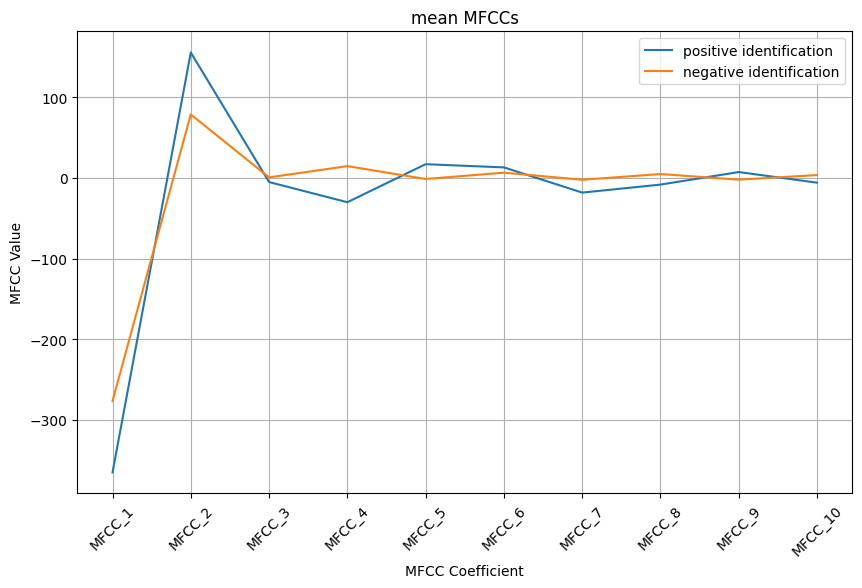

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(positive_demo_mfccs.drop(columns=['classification', 'filename']).columns, mean_demo_positive, label='positive identification')
plt.plot(positive_demo_mfccs.drop(columns=['classification', 'filename']).columns, mean_demo_negative, label='negative identification')
plt.xlabel('MFCC Coefficient')
plt.ylabel('MFCC Value')
plt.title(f"mean MFCCs")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

## Fitting SVM

In [26]:
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [27]:
detection_dataset = pd.read_csv('proper_detections_mfccs.csv')
detection_dataset.head()
X = detection_dataset[[f"MFCC_{i}" for i in range(1,11)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(X)

         MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0    -283.46750  103.699036   9.822460  32.781723   5.638542 -11.626588   
1    -248.95076   36.808964 -48.659748   0.121757   5.919672  -1.763860   
2    -178.04120  100.034120 -35.619133  17.345413  -2.705955  -9.029475   
3    -205.40433   26.761843 -52.432210  -3.396836   5.302496 -14.275190   
4    -267.22302   60.566257  -3.041984   1.264169 -12.658280  13.080815   
...         ...         ...        ...        ...        ...        ...   
2452 -304.91605  111.786370 -24.751774 -39.830790   4.879093  -4.834655   
2453 -200.71486  210.715700 -60.594750 -60.514320  50.913902  23.385450   
2454 -305.04470  139.167070   7.584106 -13.991713  20.741450   7.135438   
2455 -386.53394  181.225400  -4.558271 -42.999218  14.402380  20.014440   
2456 -460.34314   42.918434   4.790022  -2.766057   8.690411   8.011292   

         MFCC_7     MFCC_8     MFCC_9    MFCC_10  
0     -2.628025   0.126076  -0.993172  -3.018559

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'svm_CV.pkl') 


In [ ]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

### OLD

In [28]:
clf = svm.SVC(kernel='rbf') # Linear Kernel
# clf = svm.NuSVC(gamma="auto")
#Train the model using the training sets
clf.fit(X_train.values, y_train)

#Predict the response for test dataset
# y_pred = clf.predict(X_test)

SVC()

In [30]:
%%time
y_pred = clf.predict(X_test.values)

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 13.5 ms


In [31]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9695121951219512
Classification Report:
               precision    recall  f1-score   support

    negative       0.97      1.00      0.98       396
    positive       0.99      0.85      0.92        96

    accuracy                           0.97       492
   macro avg       0.98      0.93      0.95       492
weighted avg       0.97      0.97      0.97       492



## SVM on 2 features for visualization

In [62]:
X = detection_dataset[[f"MFCC_{i}" for i in range(1,3)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
print(X)

         MFCC_1      MFCC_2
0    -283.46750  103.699036
1    -248.95076   36.808964
2    -178.04120  100.034120
3    -205.40433   26.761843
4    -267.22302   60.566257
...         ...         ...
2452 -304.91605  111.786370
2453 -200.71486  210.715700
2454 -305.04470  139.167070
2455 -386.53394  181.225400
2456 -460.34314   42.918434

[2457 rows x 2 columns]


### Find best hyperparams for 2D

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

### Show best 2d Decsision boundary

In [63]:
model_2mfcc = svm.SVC(kernel='rbf')
model_2mfcc.fit(X, y)

SVC()

In [64]:
%%time
y_pred = model_2mfcc.predict(X_test.values)

CPU times: user 26.4 ms, sys: 118 µs, total: 26.5 ms
Wall time: 24.4 ms


/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [65]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8983739837398373
Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.94      0.94       396
    positive       0.75      0.72      0.73        96

    accuracy                           0.90       492
   macro avg       0.84      0.83      0.84       492
weighted avg       0.90      0.90      0.90       492



In [67]:
def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(X['MFCC_1'].min(), X['MFCC_1'].max(), 100),
                         np.linspace(X['MFCC_2'].min(), X['MFCC_2'].max(), 100))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(
        X['MFCC_1'],
        X['MFCC_2'],
        c=np.where(y == "negative", -1, 1),
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)

/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


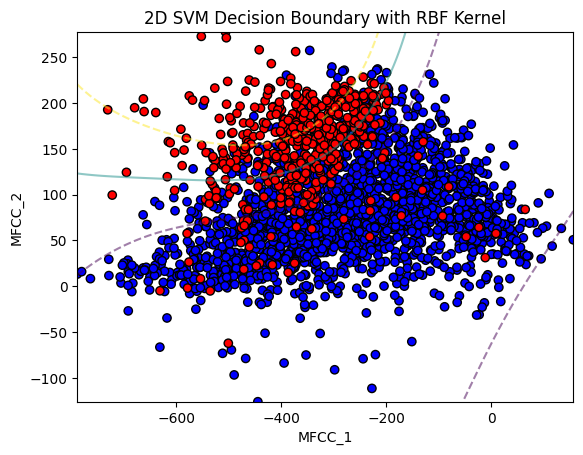

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm


# Fit the model
# model = svm.SVC(kernel='rbf')
# model.fit(X, y)

# Create grid to plot decision boundary
xx, yy = np.meshgrid(np.linspace(X['MFCC_1'].min(), X['MFCC_1'].max(), 100),
                     np.linspace(X['MFCC_2'].min(), X['MFCC_2'].max(), 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict decision function on the grid
Z = model_2mfcc.decision_function(grid).reshape(xx.shape)

# Plot decision boundary and margins
plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Scatter plot of the data points
plt.scatter(X['MFCC_1'], X['MFCC_2'], c=np.where(y == "negative", -1, 1)
            , cmap=plt.cm.bwr, edgecolors='k')

# Labeling
plt.xlabel('MFCC_1')
plt.ylabel('MFCC_2')
plt.title('2D SVM Decision Boundary with RBF Kernel')

plt.show()


/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


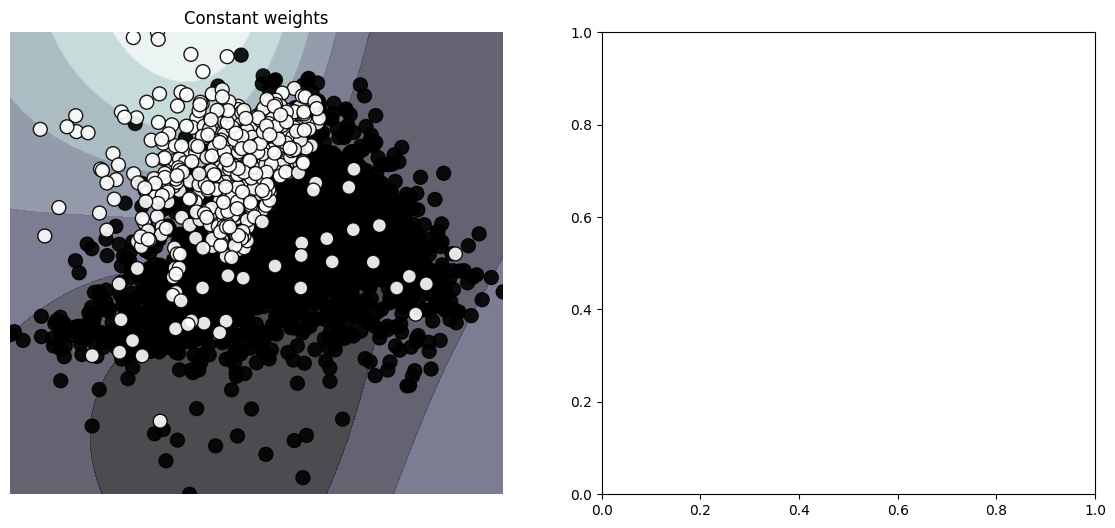

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(
    model_2mfcc, sample_weight_constant, axes[0], "Constant weights"
)
plt.show()

# Cry Classification

# Demo